In [1]:
%load_ext autoreload
%autoreload 2
import lusee
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 3.5]
matplotlib.rcParams['figure.dpi'] = 100
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
from scipy.integrate import simpson
import refspec
import os

In [2]:
beam = lusee.Beam(os.environ['LUSEE_DRIVE_DIR']+"Simulations/BeamModels/LanderRegolithComparison/eight_layer_regolith/hfss_lbl_3m_75deg.2port.fits")
f=np.logspace(-2,np.log10(50.),1000)
sky_frac_in = 1-beam.ground_fraction()
sky_frac_s = gaussian_filter(sky_frac_in,1)
sky_frac_s[0] = sky_frac_in[0]
sky_frac = interp1d(np.hstack((0,beam.freq)),np.hstack((0,sky_frac_s)),kind='quadratic')
T_sky = lusee.monosky.T_C(f).value
T_ant = sky_frac(f)*T_sky + ((1-sky_frac(f))*200)
T=lusee.Throughput(beam)

P_plasma = np.zeros_like(f)
P_plasma[f<10] = lusee.monosky.BalePlasmaEffects()(f[f<10])

T=lusee.Throughput(beam)
T.AntennaImpedanceInterp(np.array([0.1]))
P_sky_jfet = T_ant * T.T2Vsq(f)
P_plasma_jfet  = P_plasma*T.Gamma_VD(f)**2

gain = T.power_gain(f,'M')
P_sky_adc = P_sky_jfet * gain
P_plasma_adc = P_plasma_jfet * gain
P_noise_adc = T.noise(f) * gain * 2 # a factor of 2 due to two amplifiers
P_total_adc = P_sky_adc + P_plasma_adc + P_noise_adc


In [36]:
def measure  (Nsec=1, PF_amplitude=0.0006,  tone=None, bit_level=1/(2**13),bits=16, seed=10):

    cfg = refspec.SpecConfig()
    sampling_rate = cfg.sampling_rate
    block_size = cfg.Nfft ## irrelevant here
    Nsamples = int(Nsec*sampling_rate)
    Nblocks_gen = Nsamples//block_size+2*cfg.Ntaps
    Nchannels = 1
    cfg.Ntaps           = 6
    cfg.zoomin_st    = 0
    cfg.zoomin_en   = 5*4; # 500 kHz times 4 / 100kHz
    cfg.zoomin_fact  = 5;
    

    cfg.Nchannels       = 1
    cfg.Average1Size    = 60
    cfg.Average2Size    = int(Nsec*cfg.sampling_rate/(cfg.Average1Size*cfg.Nfft))
    fundamental         = cfg.fundamental_frequency()

    if tone is not None:
        source = refspec.SignalGenerator(block_size, Nchannels, Nblocks_gen, tone*1e3, sampling_rate, 100.,0.)
    else:
        raw_source = refspec.PowerSpecSource (f,P_total_adc, sampling_rate, block_size, Nchannels, Nblocks_gen, False, False, seed, True)
        if PF_amplitude>0:
            picket_fname = os.environ['REFSPEC_PATH']+'/data/samples/picket_fence_1024.txt'
            PF = refspec.CombSource(block_size, Nchannels, 1024, picket_fname, 1, PF_amplitude)
            source = refspec.SignalCombiner([raw_source, PF], True)
        else:
            source = raw_source

    output = refspec.SpecOutput(cfg)
    
    spectrometer = refspec.RefSpectrometer(source, cfg)
    spectrometer.run(output)
    
    Pkout = np.array(output.get_avg_pspec_zoom(0))#np.array([output.get_avg_pspec(0, i) for i in range(0, cfg.Nbins())])
    fout = fundamental/5*np.arange(0,len(Pkout))
    PkOutR = np.array([output.get_avg_pspec(0, i//5) for i in range(len(Pkout))])

    for i in range(1,20):
        Pkout[i*5:(i+1)*5] = Pkout[(i+1)*5-1:i*5-1:-1]


    return fout, Pkout,PkOutR



In [37]:
resp = []
tone = np.arange(75,125,0.1)
for t in tone:
    fk,Pk,Pkr = measure(0.05, tone=t)
    resp.append(Pk[20:25])
resp = np.array(resp)
cal = np.sum(resp, axis=0)

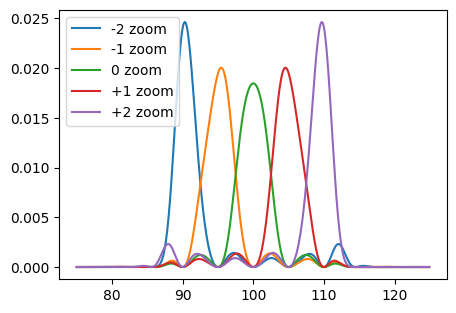

In [ ]:
for i in range(5):
    l = f'{i-2}' if i-2<1 else f'+{i-2}'
    plt.plot(tone, resp[:,i]/cal[i], label = f'{l} zoom')
plt.legend()

In [35]:
cal

array([10.71340984, 10.87275216, 10.83320515, 10.87275214, 10.71340985])